In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mprod import  m_prod
from mprod import  generate_haar, generate_dct
from numpy import linalg as LA
from scipy.stats import ortho_group
from scipy.fft import dct, idct, rfft, irfft

In [2]:
def tensor_frob_norm(A):
    return np.sqrt((A**2).sum())

def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

# assighn random tensor A (PSD with dominant diagonal) and b

In [3]:
m, p, n = 1000, 100, 10
funm_dct, invm_dct = generate_haar(n, random_state=121)

np.random.seed(0)
A_orig = np.random.rand(m, p, n)
# precond
# A_tensor = m_prod(A_orig.transpose((1,0,2)), A_orig, funm_dct, invm_dct)+10*np.array(n*[np.identity(p)]).transpose((1,2,0))
A_tensor = m_prod(A_orig.transpose((1,0,2)), A_orig, funm_dct, invm_dct)
X_true = np.random.randn(p, 1, n)
B = m_prod(A_tensor, X_true, funm_dct, invm_dct)

A_tensor_mult_M = funm_dct(A_tensor)

print('\ncondition number of each frontal slice')
for i in range(n):
    print(LA.cond(A_tensor[:,:,i]))
    
print('\ncondition number of each frontal slice of A^hat')        
for i in range(n):
    print(LA.cond(A_tensor_mult_M[:,:,i]))


condition number of each frontal slice
351.40903197504207
12476.743630001283
114723.45182081225
341.2229681667
620.4312435944656
2343512.9181069834
728330.1984372275
237.3971474750833
557.3595573110449
2522.0584469019664

condition number of each frontal slice of A^hat
2742.178146769511
232.22449553521238
211.716587930182
1790.7403330130733
9.60784516923714
799.8932930894347
31.95389651148932
3.673781829147786
342.8921126695719
179.43088608394834


In [4]:
def facewice_tree(A, B, C=None):
    if C is None:
        mult = np.einsum('mpi,pli->mli', A, B)
    else:
        mult = np.einsum('mpi,pli->mli',np.einsum('mpi,pli->mli', A, B), C)
    return mult

# create precondition tensor - not working for matrix rand, working for randN

In [5]:
# m, p, n = 1000, 100, 1

# np.random.seed(0)
# A_orig = np.random.rand(m, p, n)
# # precond
# # A_tensor = m_prod(A_orig.transpose((1,0,2)), A_orig, funm_dct, invm_dct)+10*np.array(n*[np.identity(p)]).transpose((1,2,0))
# A_tensor_mult_M = facewice_tree(A_orig.transpose((1,0,2)), A_orig)

    
# print('\ncondition number of each frontal slice of A^hat')        
# for i in range(n):
#     print(LA.cond(A_tensor_mult_M[:,:,i]))

In [6]:
N = A_tensor_mult_M.shape[0]
omega = 2*(1-np.pi/N)
omega

1.937168146928204

In [7]:
D_flat = np.diagonal(A_tensor_mult_M, axis1=0, axis2=1)
D_tensor = np.zeros_like(A_tensor_mult_M)
for i in range(A_tensor_mult_M.shape[0]):
    D_tensor[i,i,:] = D_flat[:,i]

In [8]:
E_tensor = np.zeros(A_tensor_mult_M.shape)
for i in range(A_tensor_mult_M.shape[-1]):
    E_tensor[:,:,i] = np.triu(A_tensor_mult_M[:,:,i], k=1).T

In [9]:
from scipy import linalg

def facewice_inverse(D):
    D_inv = np.zeros_like(D)
    for i in range(D.shape[-1]):
        # D[:,:,i] = linalg.inv(D[:,:,i])
        D_inv[:,:,i] = linalg.solve_triangular(D[:,:,i], np.identity(D.shape[0]), lower=True)
    return D_inv

In [10]:
def m_prod_three(A, B, C, fun_m, inv_m):
    
    a_hat = fun_m(A)
    b_hat = fun_m(B)
    c_hat = fun_m(C)

    mult_hat = np.einsum('mpi,pli->mli',np.einsum('mpi,pli->mli', a_hat, b_hat), c_hat)
    return inv_m(mult_hat)

In [11]:
# C_tensor = omega/(2-omega)*facewice_tree(D_tensor/omega+E_tensor, facewice_inverse(D_tensor), D_tensor/omega+E_tensor.transpose(1,0,2))
# B_tensor = np.sqrt(omega/(2-omega))*facewice_tree(D_tensor+E_tensor, np.sqrt(facewice_inverse(D_tensor)))

In [12]:
# P_tensor_hat = facewice_inverse(T_tensor)
# P_tensor = invm_dct(P_tensor_hat)

In [13]:
B_inv_hat = np.sqrt(omega/(2-omega))*facewice_tree(np.sqrt(D_tensor), facewice_inverse(D_tensor+E_tensor))

In [14]:
A_tensor_tilde = facewice_tree(B_inv_hat, A_tensor_mult_M, B_inv_hat.transpose(1,0,2))

In [15]:
# funm_dct(A_tensor_tilde).shape

In [16]:
A_tensor_tilde.shape

(100, 100, 10)

In [17]:
print('Condition number of each frontal slice of A^hat')
for i in range(A_tensor_tilde.shape[-1]):
    print('Preconditioned: ', LA.cond(A_tensor_tilde[:,:,i]), 'Original: ' , LA.cond(A_tensor_mult_M[:,:,i]))
    print('diff Original-Preconditioned = ', LA.cond(A_tensor_mult_M[:,:,i])-LA.cond(A_tensor_tilde[:,:,i]))

Condition number of each frontal slice of A^hat
Preconditioned:  12753.61701092738 Original:  2742.178146769511
diff Original-Preconditioned =  -10011.43886415787
Preconditioned:  665.5821842991342 Original:  232.22449553521238
diff Original-Preconditioned =  -433.3576887639218
Preconditioned:  616.1175982589378 Original:  211.716587930182
diff Original-Preconditioned =  -404.4010103287559
Preconditioned:  9161.299470336126 Original:  1790.7403330130733
diff Original-Preconditioned =  -7370.559137323053
Preconditioned:  3.2944455051961476 Original:  9.60784516923714
diff Original-Preconditioned =  6.3133996640409915
Preconditioned:  3465.410227582163 Original:  799.8932930894347
diff Original-Preconditioned =  -2665.516934492728
Preconditioned:  24.450328684446262 Original:  31.95389651148932
diff Original-Preconditioned =  7.503567827043057
Preconditioned:  1.3011928410666973 Original:  3.673781829147786
diff Original-Preconditioned =  2.3725889880810884
Preconditioned:  1124.64337265

In [18]:
B_inv = invm_dct(B_inv_hat)
B_inv_T = invm_dct(B_inv_hat.transpose(1,0,2))

In [19]:
B_inv_hat[:,:,0]

array([[ 1.61098041e-01,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.49625715e-01,  1.62580283e-01,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.13666481e-02, -1.50692829e-01,  1.63379265e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-1.67887012e-04,  5.41300257e-04, -1.64193888e-04, ...,
         1.62877395e-01,  0.00000000e+00,  0.00000000e+00],
       [-8.63686338e-04, -2.53586193e-04,  2.49686171e-04, ...,
        -1.51356113e-01,  1.62538081e-01,  0.00000000e+00],
       [ 1.14725970e-03, -7.20979139e-04,  9.50875986e-05, ...,
        -1.08284408e-02, -1.50754962e-01,  1.62571886e-01]])

In [20]:
A_tensor_prec = m_prod_three(B_inv, A_tensor, B_inv_T, funm_dct, invm_dct)

In [21]:
A_tensor_prec_hat = facewice_tree(B_inv_hat, A_tensor_mult_M, B_inv_hat.transpose(1,0,2))

In [22]:
print('Condition number of each frontal slice of A^hat')
for i in range(A_tensor_prec_hat.shape[-1]):
    print('Preconditioned: ', LA.cond(A_tensor_prec_hat[:,:,i]), 'Original: ' , LA.cond(A_tensor_mult_M[:,:,i]))

Condition number of each frontal slice of A^hat
Preconditioned:  12753.61701092738 Original:  2742.178146769511
Preconditioned:  665.5821842991342 Original:  232.22449553521238
Preconditioned:  616.1175982589378 Original:  211.716587930182
Preconditioned:  9161.299470336126 Original:  1790.7403330130733
Preconditioned:  3.2944455051961476 Original:  9.60784516923714
Preconditioned:  3465.410227582163 Original:  799.8932930894347
Preconditioned:  24.450328684446262 Original:  31.95389651148932
Preconditioned:  1.3011928410666973 Original:  3.673781829147786
Preconditioned:  1124.6433726570835 Original:  342.8921126695719
Preconditioned:  486.2058864624234 Original:  179.43088608394834


In [23]:
print('wheather the slices are psd?')
for i in range(n):
    nu = is_pos_def(A_tensor_mult_M[:,:,i])
    print(nu)
    if ~nu:
        eigs = np.linalg.eigvals(A_tensor_mult_M[:,:,i])
        print('smallest eigenvalue = ', eigs.min())


wheather the slices are psd?
True
True
True
True
True
True
True
True
True
True


In [24]:
def normalize(X, funm_dct, invm_dct, tol=10**-10):
    V = funm_dct(X)
    m, p, n = X.shape #p==1
    a_all = np.ones(n)
    for i in range(n):
        a = np.linalg.norm(V[:,:,i].squeeze(), None)
        # print(a)
        a_all[i]=a  
        if a>tol:
            V[:,:,i] = V[:,:,i]/a
        else:
            print(a)
            V[:,:,i] = np.random.randn(m, 1)
            a = np.linalg.norm(V[:,:,i].squeeze(), None)
            V[:,:,i] = V[:,:,i]/a
            a_all[i]=0
    V = invm_dct(V)
    a_all = invm_dct(a_all.reshape((1,1,-1)))
    return V, a_all

In [25]:
I_hat= np.ones((1,1,n))                                                      

In [26]:
def inverse_of_tube(a, funm_dct, invm_dct):
    _,_,n = a.shape

    a_hat = funm_dct(a)
    a_inv_hat = np.divide(I_hat,a_hat)
    a_inv = invm_dct(a_inv_hat)
    # a_inv[a_inv==np.nan]=0
    # a_inv[a_inv==np.inf]=0
    # a_inv[a_inv==-np.inf]=0
    # print(a_inv)
    return a_inv

In [27]:
a = np.random.rand(1,1,10)
a_inv = inverse_of_tube(a, funm_dct, invm_dct)
m_prod(a, a_inv,funm_dct, invm_dct)
print('the hat tube is equal to identity tube (in transformed space):')
funm_dct(m_prod(a_inv,a,funm_dct, invm_dct))

the hat tube is equal to identity tube (in transformed space):


array([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]])

In [28]:
def CG_M_tensor(A_tensor, B, funm_dct, invm_dct, iters, tol=10**-10, X_zero=None, X_true=None):
    m, p, n = A_tensor.shape
    if m!=p:
        print('error: the frontal slices are not square matrices')
        return None
    if X_zero==None:
        X_zero = np.zeros((p, 1, n))
        # X_zero = np.random.rand(p,1, n)

    # R = B-m_prod(A_tensor, X_zero, funm_dct, invm_dct)
    R, a_all = normalize(B, funm_dct, invm_dct, tol)
    # print(a_all)
    D = R.copy()
    X = X_zero.copy()
    error_each_step = []
    for i in range(iters):
        alpha_num = m_prod(R.transpose((1,0,2)), R, funm_dct, invm_dct)
        alpha_den = m_prod_three(D.transpose((1,0,2)),A_tensor, D, funm_dct, invm_dct)

        alpha = m_prod(alpha_num,inverse_of_tube(alpha_den, funm_dct, invm_dct),funm_dct, invm_dct) 
        X = X+m_prod(D, alpha, funm_dct, invm_dct)
        R_next = R-m_prod_three(A_tensor, D, alpha, funm_dct, invm_dct)
        beta_num = m_prod(R_next.transpose((1,0,2)), R_next, funm_dct, invm_dct)
        beta_den = m_prod(R.transpose((1,0,2)), R, funm_dct, invm_dct)
        beta = m_prod(inverse_of_tube(beta_den, funm_dct, invm_dct), beta_num,funm_dct, invm_dct)
        D = R_next+m_prod(D, beta, funm_dct, invm_dct)
        # print('D', D[0])
        R = R_next.copy()
        if type(X_true).__module__ == np.__name__:
            X_new = m_prod(X, a_all, funm_dct, invm_dct)
            # X_new = X.copy()
            error_each_step.append(tensor_frob_norm(X_new-X_true))
    if type(X_true).__module__ == np.__name__:
        return X_new, error_each_step

## random: A_orig - normal, x-normal

In [29]:
np.random.seed(0)
A_orig = np.random.randn(m, p, n)

A_tensor = m_prod(A_orig.transpose((1,0,2)), A_orig, funm_dct, invm_dct)+10*np.array(n*[np.identity(p)]).transpose((1,2,0))
X_true = np.random.randn(p, 1, n)
B = m_prod(A_tensor, X_true, funm_dct, invm_dct)

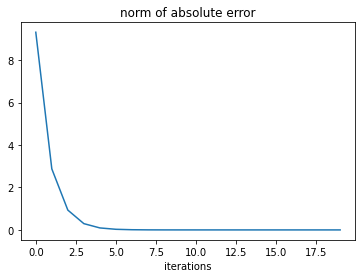

In [30]:
X, error = CG_M_tensor(A_tensor, B, funm_dct, invm_dct, iters=20, X_zero=None, X_true=X_true)
plt.plot(error)
plt.title('norm of absolute error')
plt.xlabel('iterations')
plt.show()

In [31]:
error[-1]

1.3662980021724064e-09

### the next iterations are NaN

## random: A_orig - uniform, x-normal

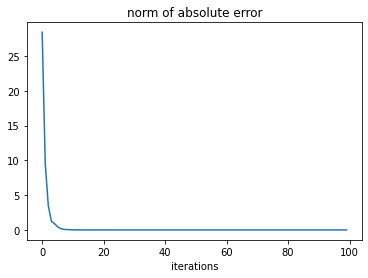

In [32]:
np.random.seed(0)
A_orig = np.random.rand(m, p, n)

A_tensor = m_prod(A_orig.transpose((1,0,2)), A_orig, funm_dct, invm_dct)+10*np.array(n*[np.identity(p)]).transpose((1,2,0))
X_true = np.random.randn(p, 1, n)
B = m_prod(A_tensor, X_true, funm_dct, invm_dct)

X, error = CG_M_tensor(A_tensor, B, funm_dct, invm_dct, iters=100, X_zero=None, X_true=X_true)
plt.plot(error)
plt.title('norm of absolute error')
plt.xlabel('iterations')
plt.show()

## random: A_orig - normal, x-uniform

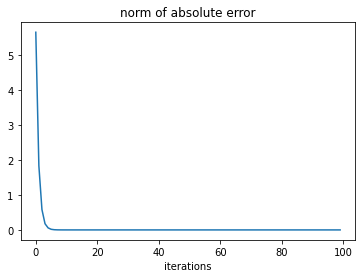

In [33]:
np.random.seed(0)
A_orig = np.random.randn(m, p, n)

A_tensor = m_prod(A_orig.transpose((1,0,2)), A_orig, funm_dct, invm_dct)+10*np.array(n*[np.identity(p)]).transpose((1,2,0))
X_true = np.random.rand(p, 1, n)
B = m_prod(A_tensor, X_true, funm_dct, invm_dct)

X, error = CG_M_tensor(A_tensor, B, funm_dct, invm_dct, iters=100, X_zero=None, X_true=X_true)
plt.plot(error)
plt.title('norm of absolute error')
plt.xlabel('iterations')
plt.show()

## random: A_orig - uniform, x-uniform

/tmp/ipykernel_321665/467913587.py:5: RuntimeWarning: divide by zero encountered in true_divide
  a_inv_hat = np.divide(I_hat,a_hat)
/home/anna/my_project_dir/my_project_env/lib/python3.8/site-packages/mprod/_base.py:98: RuntimeWarning: invalid value encountered in matmul
  return (M @ A.transpose((2, 1, 0)).reshape(n, m * p)).reshape((n, p, m)).transpose((2, 1, 0))


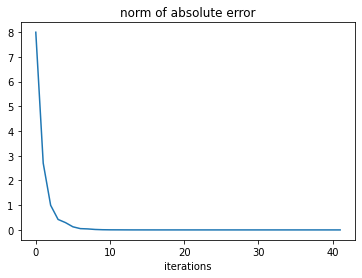

In [34]:
np.random.seed(0)
A_orig = np.random.rand(m, p, n)

A_tensor = m_prod(A_orig.transpose((1,0,2)), A_orig, funm_dct, invm_dct)+10*np.array(n*[np.identity(p)]).transpose((1,2,0))
X_true = np.random.rand(p, 1, n)
B = m_prod(A_tensor, X_true, funm_dct, invm_dct)

X, error = CG_M_tensor(A_tensor, B, funm_dct, invm_dct, iters=100, X_zero=None, X_true=X_true)
plt.plot(error)
plt.title('norm of absolute error')
plt.xlabel('iterations')
plt.show()